In [1]:
import cftime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import genextreme as gev
from scipy import stats
import xclim as xc
from xclim import sdba
from xclim.sdba import nbutils

from unseen import fileio
from unseen import eva
from unseen import moments
from unseen import similarity
from unseen import stability
from unseen import bias_correction
from unseen import time_utils

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xclim/sdba/__init__.py:22: FutureWarning: The SDBA submodule is in the process of being split from `xclim` in order to facilitate development and effective maintenance of the SDBA utilities. The `xclim.sdba` functionality will change in the future. For more information, please visit https://xsdba.readthedocs.io/en/latest/.
  warnings.warn(


In [2]:
lat = {}
lon = {}

lat['Katherine'] = -14.5
lon['Katherine'] = 132.3

lat['Surat'] = -27.2
lon['Surat'] = 149.1

lat['Miena'] = -42.0
lon['Miena'] = 146.7

In [3]:
location = 'Miena'

### Observations

In [4]:
txx_obs_file = '/Users/irv033/Desktop/unseen-bias/txx_AGCD-CSIRO_1901-2024_annual-jul-to-jun_AUS300i.nc'

In [5]:
ds_obs = fileio.open_dataset(txx_obs_file)

In [6]:
da_obs = ds_obs['tasmax'].sel({'lat': lat[location], 'lon': lon[location]}, method='nearest')

In [7]:
da_obs = da_obs.compute()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=

In [8]:
df_obs = da_obs.to_dataframe()

In [9]:
ranked_years = df_obs.sort_values(by='tasmax', ascending=False)
print(ranked_years.head(n=10))

                      lat    lon  event_time     tasmax
time                                                   
2020-06-30 00:00:00 -42.0  146.5  2020-01-31  33.026836
1982-06-30 00:00:00 -42.0  146.5  1982-02-15  32.948212
1943-06-30 00:00:00 -42.0  146.5  1943-01-28  32.565174
2009-06-30 00:00:00 -42.0  146.5  2009-01-30  32.514805
2013-06-30 00:00:00 -42.0  146.5  2013-01-04  32.233288
1973-06-30 00:00:00 -42.0  146.5  1973-01-20  32.183025
1991-06-30 00:00:00 -42.0  146.5  1991-01-03  32.145985
1967-06-30 00:00:00 -42.0  146.5  1967-02-07  31.945469
1960-06-30 00:00:00 -42.0  146.5  1960-01-16  31.564096
2003-06-30 00:00:00 -42.0  146.5  2003-01-25  31.558460


In [10]:
linear_fit_obs = np.polyfit(da_obs.time.dt.year.values, da_obs.values, 1)
linear_data_obs = np.polyval(linear_fit_obs, da_obs.time.dt.year.values)

In [11]:
base_mean_obs = da_obs.sel(time=slice('1972-01-01', '2018-12-31')).mean().values

In [12]:
da_obs_detrended = (da_obs - linear_data_obs) + base_mean_obs
da_obs_detrended.attrs = da_obs.attrs

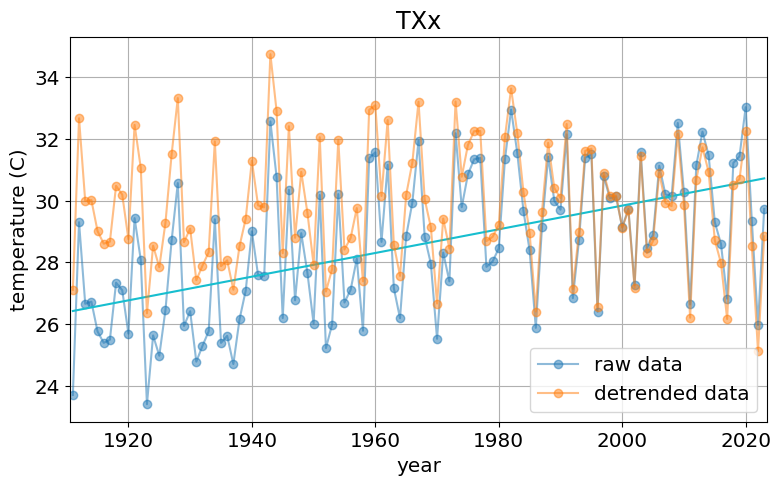

In [13]:
fig, ax = plt.subplots(figsize=[9, 5])
years = da_obs['time'].dt.year.values
plt.plot(years, da_obs.values, marker='o', label='raw data', color='tab:blue', alpha=0.5)
plt.plot(years, linear_data_obs, color='tab:cyan')
plt.plot(years, da_obs_detrended.values, marker='o', label='detrended data', color='tab:orange', alpha=0.5)
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title('TXx')
plt.ylabel('temperature (C)')
plt.xlabel('year')
plt.legend()
plt.grid()

In [14]:
gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended = eva.fit_gev(da_obs_detrended.values)
print(f'Shape parameter: {gev_shape_obs_detrended:.2f}')
print(f'Location parameter: {gev_loc_obs_detrended:.2f}')
print(f'Scale parameter: {gev_scale_obs_detrended:.2f}')

Shape parameter: 0.27
Location parameter: 29.12
Scale parameter: 1.93


### Model data

In [15]:
txx_model_file = '/Users/irv033/Desktop/unseen-bias/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_AUS300i.nc'

In [16]:
ds_model = fileio.open_dataset(txx_model_file)

In [17]:
da_model = ds_model['tasmax'].sel({'lat': lat[location], 'lon': lon[location]}, method='nearest')

In [18]:
da_model = da_model.compute()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)


In [19]:
da_model_stacked = da_model.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [20]:
linear_fit_model = np.polyfit(da_model_stacked.time.dt.year.values, da_model_stacked.values, 1)
linear_data_model = np.polyval(linear_fit_model, np.unique(da_model_stacked.time.dt.year.values))

In [21]:
da_model_stacked_base = time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])
base_mean_model = da_model_stacked_base.mean().values

In [22]:
value_year_pairs = np.column_stack((da_model_stacked.values, da_model_stacked.time.dt.year.values))
detrended_data = []
for value, year in value_year_pairs:
    af = np.polyval(linear_fit_model, year)
    detrended_value = value - af + base_mean_model
    detrended_data.append(detrended_value)
detrended_data = np.array(detrended_data)

In [23]:
da_model_detrended_stacked = da_model_stacked * 0 + detrended_data
da_model_detrended_stacked.attrs = da_model_stacked.attrs

In [24]:
da_model_detrended = da_model_detrended_stacked.unstack()

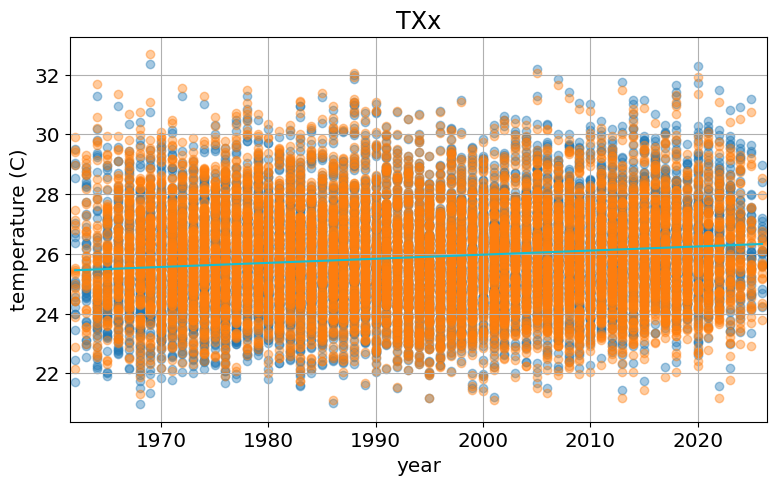

In [25]:
fig, ax = plt.subplots(figsize=[9, 5])
years = da_model_stacked['time'].dt.year.values
unique_years = np.unique(da_model_stacked.time.dt.year.values)
plt.scatter(years, da_model_stacked.values, marker='o', color='tab:blue', alpha=0.4, label='raw data')
plt.plot(unique_years, linear_data_model, color='tab:cyan')
plt.scatter(years, da_model_detrended_stacked.values, marker='o', color='tab:orange', alpha=0.4, label='detrended data')
plt.xlim(unique_years[0] - 0.5, unique_years[-1] + 0.5)
plt.title('TXx')
plt.ylabel('temperature (C)')
plt.xlabel('year')
#plt.legend()
plt.grid()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


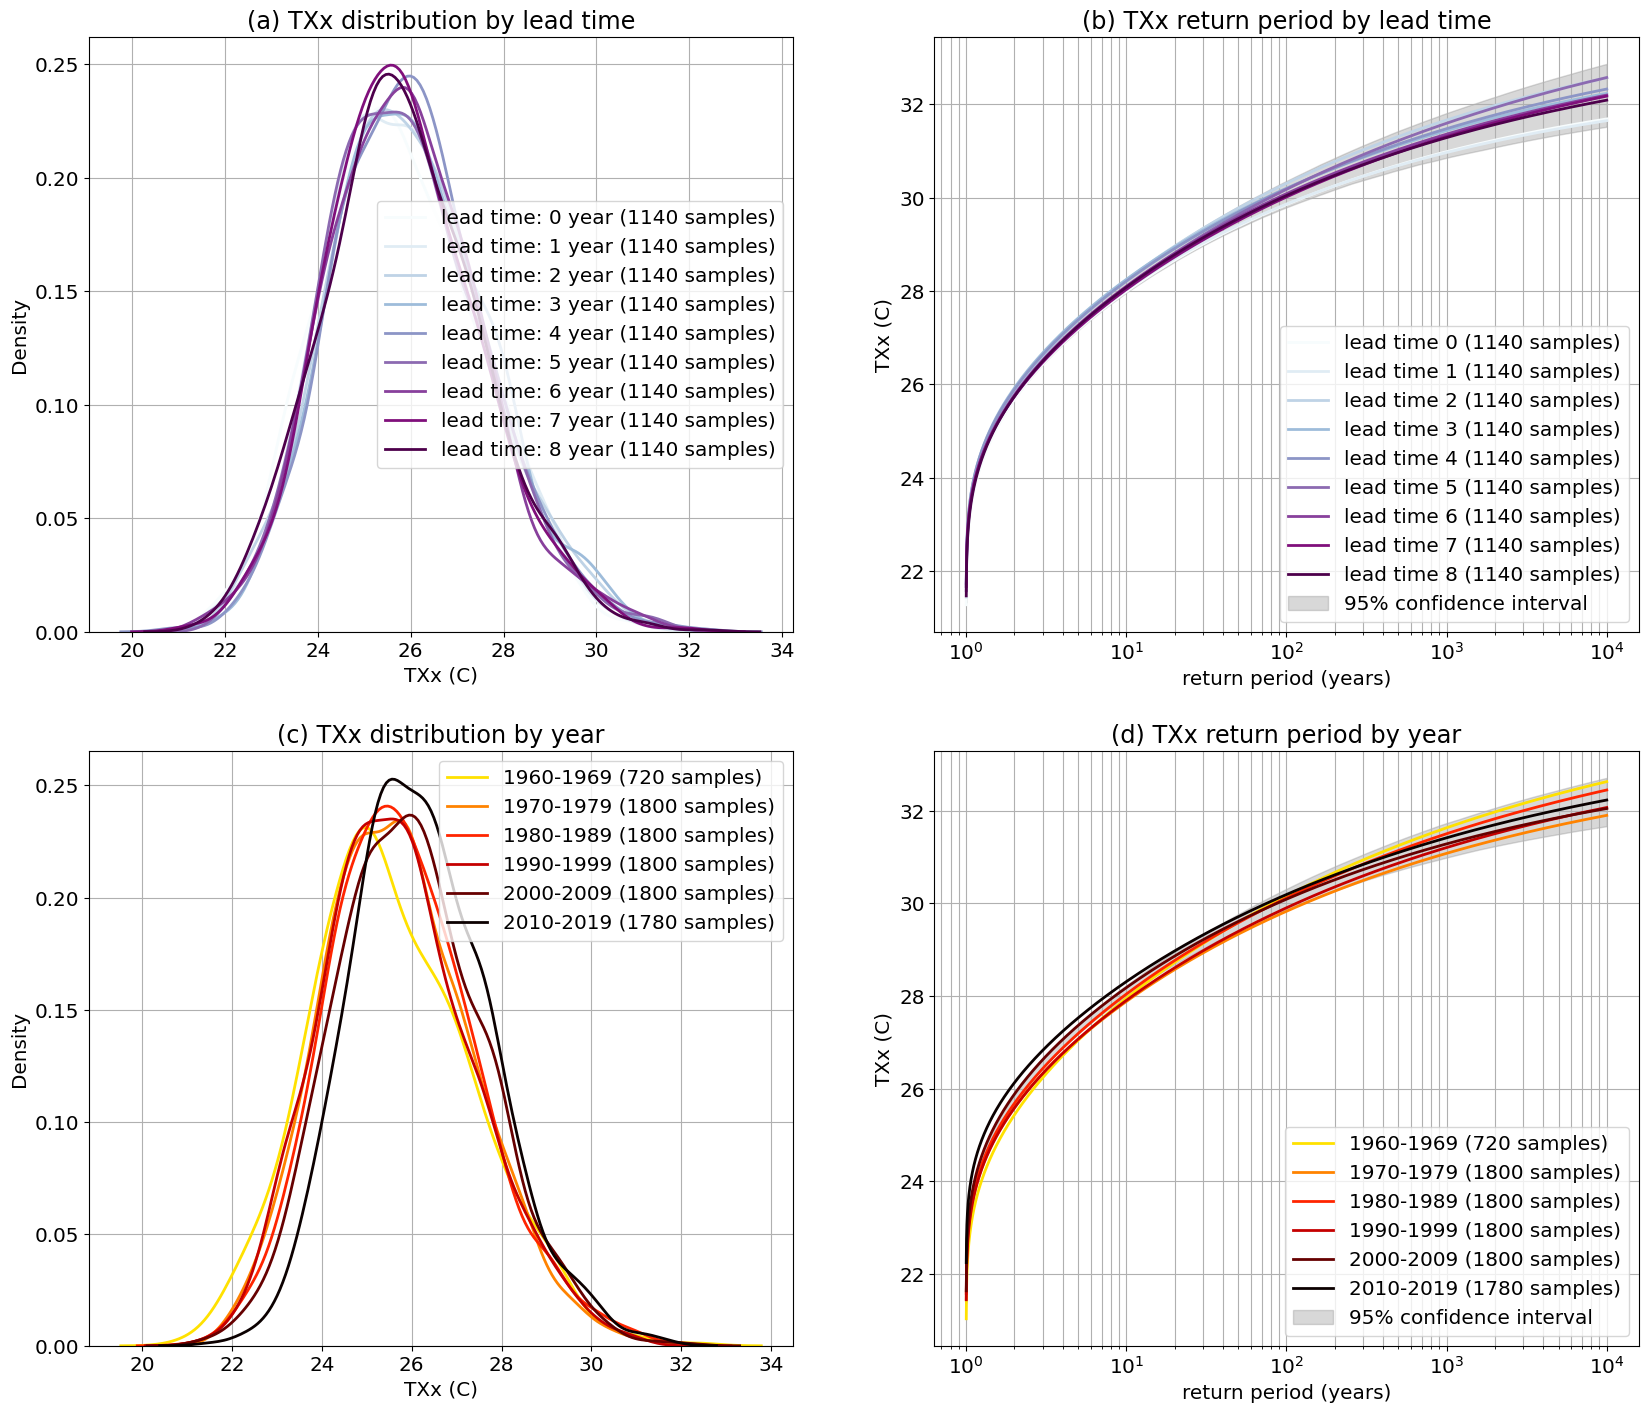

In [26]:
stability.create_plot(
    da_model,
    'TXx',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='TXx (C)',
#    ylim=(0, 450),
)

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


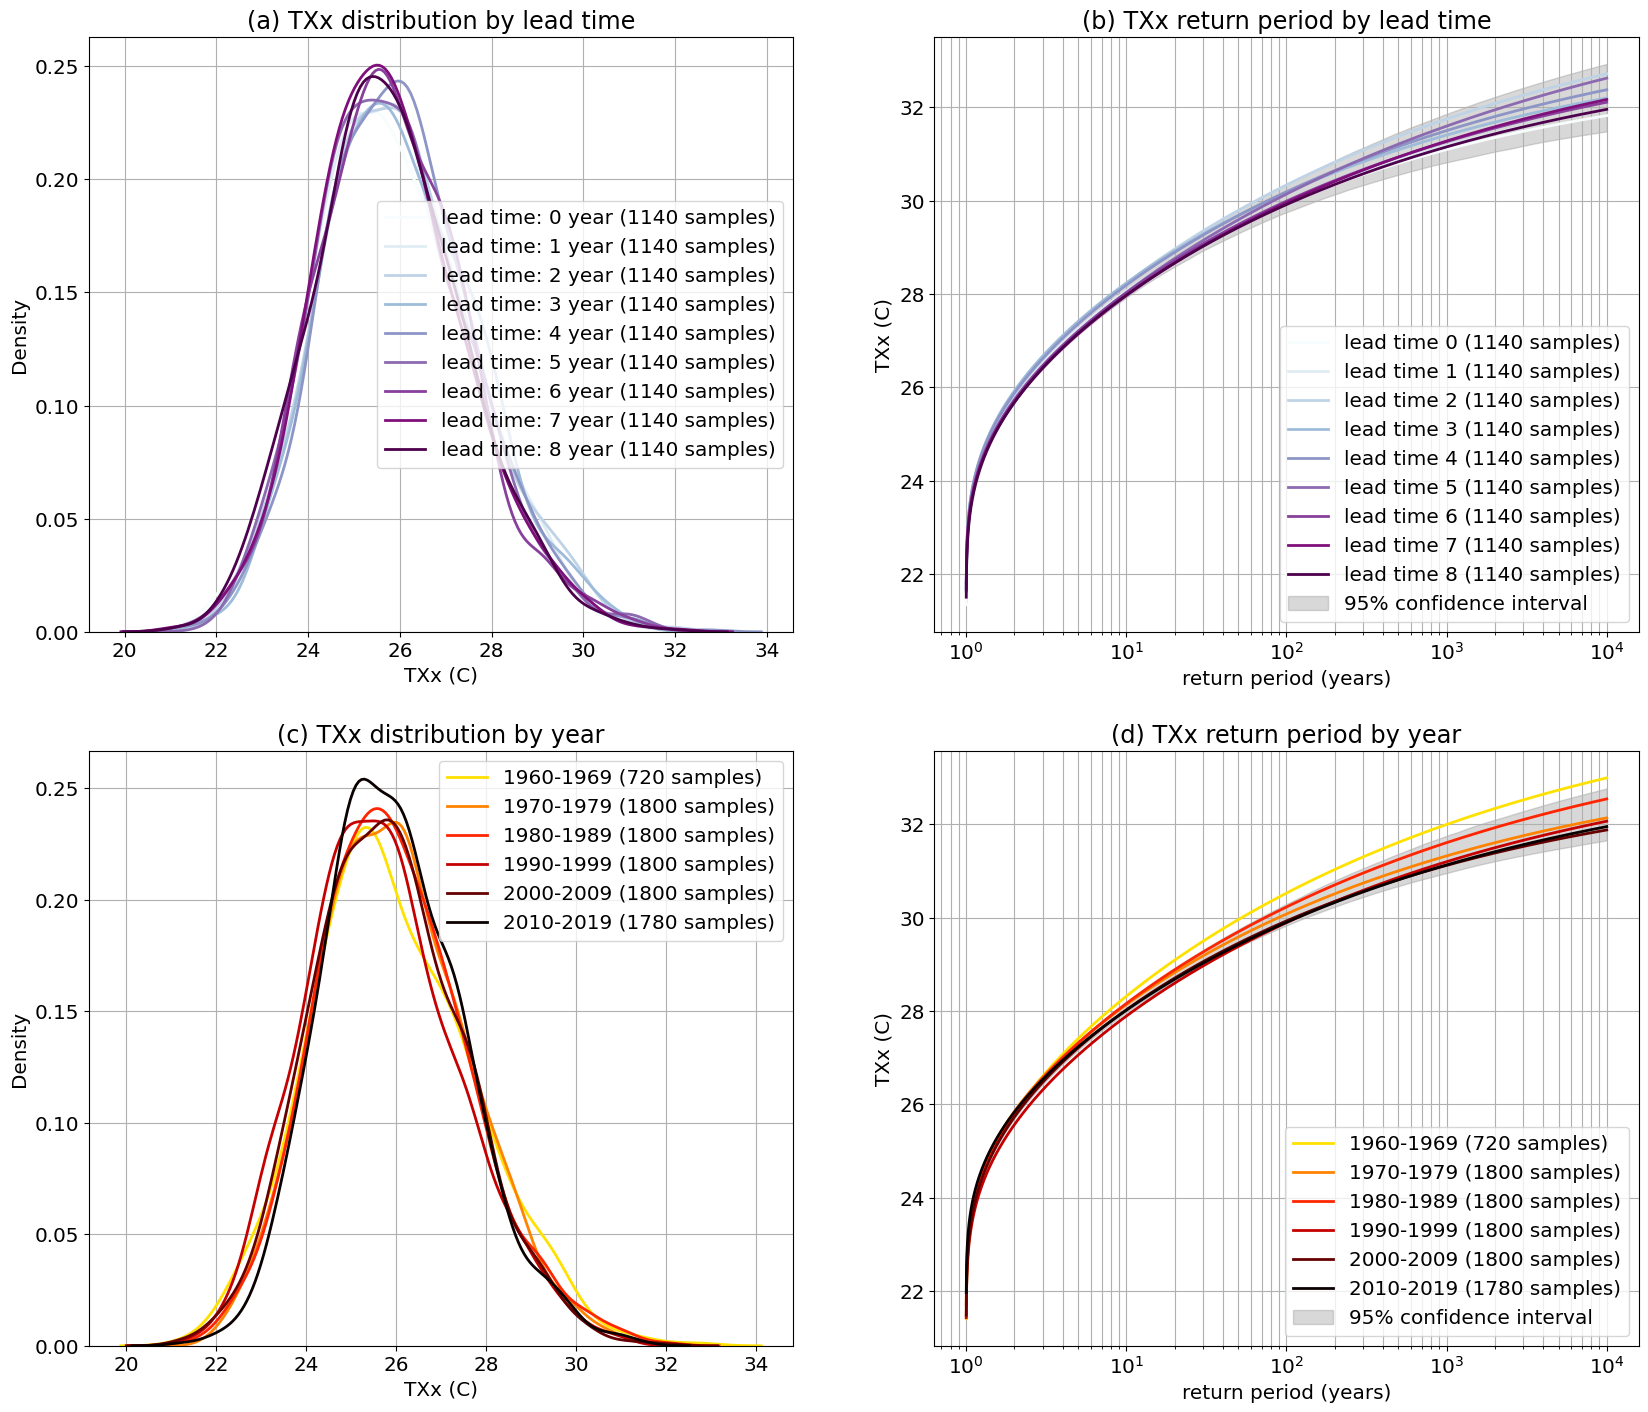

In [27]:
stability.create_plot(
    da_model_detrended,
    'TXx',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='TXx (C)',
#    ylim=(0, 450),
)

In [28]:
gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended = eva.fit_gev(da_model_detrended_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended:.2f}')
print(f'Location parameter: {gev_loc_model_detrended:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended:.2f}')

Shape parameter: 0.18
Location parameter: 25.23
Scale parameter: 1.54


### Mean correction

#### Additive

In [29]:
bias_mean_add = bias_correction.get_bias(
    da_model_detrended,
    da_obs_detrended,
    'additive',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [30]:
da_model_detrended_bc_mean_add = bias_correction.remove_bias(da_model_detrended, bias_mean_add, 'additive')

In [31]:
da_model_detrended_bc_mean_add = da_model_detrended_bc_mean_add.compute()

In [32]:
da_model_detrended_bc_mean_add_stacked = da_model_detrended_bc_mean_add.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [33]:
gev_shape_model_detrended_bc_mean_add, gev_loc_model_detrended_bc_mean_add, gev_scale_model_detrended_bc_mean_add = eva.fit_gev(da_model_detrended_bc_mean_add_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_mean_add:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_mean_add:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_mean_add:.2f}')

Shape parameter: 0.18
Location parameter: 29.38
Scale parameter: 1.54


#### Multiplicative

In [34]:
bias_mean_mulc = bias_correction.get_bias(
    da_model_detrended,
    da_obs_detrended,
    'multiplicative',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [35]:
da_model_detrended_bc_mean_mulc = bias_correction.remove_bias(da_model_detrended, bias_mean_mulc, 'multiplicative')
da_model_detrended_bc_mean_mulc = da_model_detrended_bc_mean_mulc.compute()

In [36]:
da_model_detrended_bc_mean_mulc_stacked = da_model_detrended_bc_mean_mulc.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [37]:
gev_shape_model_detrended_bc_mean_mulc, gev_loc_model_detrended_bc_mean_mulc, gev_scale_model_detrended_bc_mean_mulc = eva.fit_gev(da_model_detrended_bc_mean_mulc_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_mean_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_mean_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_mean_mulc:.2f}')

Shape parameter: 0.18
Location parameter: 29.28
Scale parameter: 1.79


### Quantile correction

In [38]:
nquantiles = 10
quantile_array = xc.sdba.utils.equally_spaced_nodes(nquantiles)

In [39]:
quantile_array

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [40]:
da_model_detrended_q = nbutils.quantile(
    da_model_detrended_stacked,
    quantile_array,
    ['sample']
)
# time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])

In [41]:
da_model_detrended_q.values

array([23.34394742, 24.21393066, 24.72217671, 25.14280538, 25.56593805,
       25.98280634, 26.41208523, 26.95516256, 27.59837332, 28.80070145])

In [42]:
da_obs_detrended_q = nbutils.quantile(
    da_obs_detrended,
    quantile_array,
    ['time']
)
# time_utils.select_time_period(da_obs.copy(), ['1972-01-01', '2018-12-31']),

In [43]:
da_obs_detrended_q.values

array([26.61367112, 27.86579623, 28.52235494, 28.79843478, 29.41165502,
       30.00268644, 30.51162496, 31.4348436 , 32.16585822, 32.99945738])

In [44]:
bias_quantile_add = da_model_detrended_q.values - da_obs_detrended_q.values

In [45]:
bias_quantile_add_cubic_fit = np.polyfit(quantile_array, bias_quantile_add, 3)

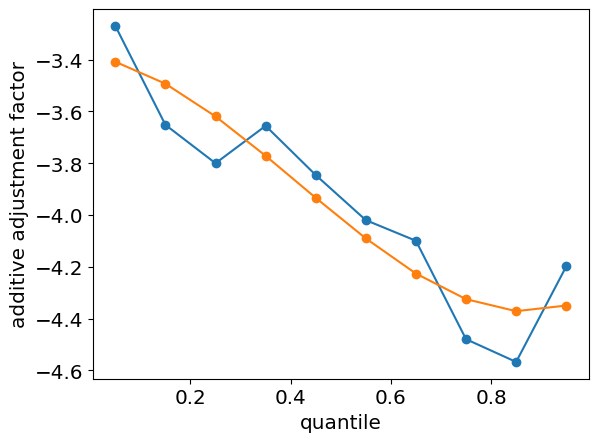

In [46]:
plt.plot(quantile_array, bias_quantile_add, marker='o')
cubic_data = np.polyval(bias_quantile_add_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('additive adjustment factor')
plt.show()

In [47]:
bias_quantile_mulc = da_model_detrended_q.values / da_obs_detrended_q.values

In [48]:
bias_quantile_mulc_cubic_fit = np.polyfit(quantile_array, bias_quantile_mulc, 3)

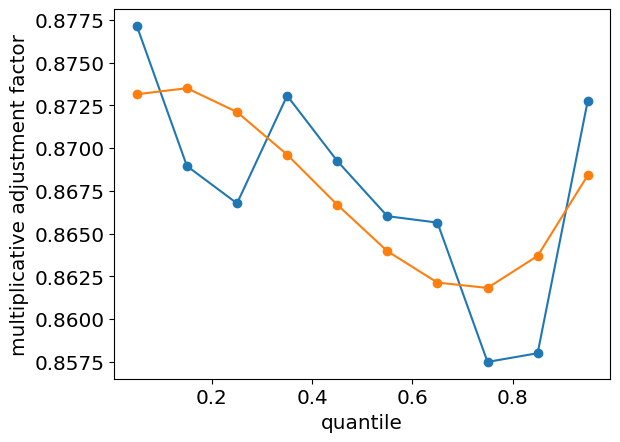

In [49]:
plt.plot(quantile_array, bias_quantile_mulc, marker='o')
cubic_data = np.polyval(bias_quantile_mulc_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('multiplicative adjustment factor')
plt.show()

In [50]:
#def get_adjustment_factor(value, quantiles, adjustment_factors):
#    """Find the adjustment factor corresponding to the closest quantile."""
#
#    assert quantiles.shape == adjustment_factors.shape
#    
#    difference_array = np.absolute(quantiles - value)
#    index = difference_array.argmin()
#    adjustment_factor = adjustment_factors[index]
#
#    return adjustment_factor
#
#vget_adjustment_factor = np.vectorize(get_adjustment_factor, excluded=['quantiles', 'adjustment_factors'])


def get_smooth_adjustment_factor(value, data, af_cubic_fit):
    """Find the adjustment factor."""

    quantile = stats.percentileofscore(data, value) / 100
    af = np.polyval(af_cubic_fit, quantile)

    return af

vget_smooth_adjustment_factor = np.vectorize(get_smooth_adjustment_factor, excluded=['data', 'af_cubic_fit'])

#### Additive

In [51]:
#af_add = vget_adjustment_factor(
#    da_model_stacked.values,
#    quantiles=da_model_q.values,
#    adjustment_factors=bias_quantile_add,
#)
af_add = vget_smooth_adjustment_factor(
    da_model_detrended_stacked.values,
    data=da_model_detrended_stacked.values,
    af_cubic_fit=bias_quantile_add_cubic_fit,
)

In [52]:
da_model_detrended_bc_quantile_add = da_model_detrended_stacked - af_add

In [53]:
gev_shape_model_detrended_bc_quantile_add, gev_loc_model_detrended_bc_quantile_add, gev_scale_model_detrended_bc_quantile_add = eva.fit_gev(da_model_detrended_bc_quantile_add.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_quantile_add:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_quantile_add:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_quantile_add:.2f}')

Shape parameter: 0.22
Location parameter: 29.09
Scale parameter: 1.90


#### Multiplicative

In [54]:
#af_mulc = vget_adjustment_factor(
#    da_model_stacked.values,
#    quantiles=da_model_q.values,
#    adjustment_factors=bias_quantile_mulc,
#)
af_mulc = vget_smooth_adjustment_factor(
    da_model_detrended_stacked.values,
    data=da_model_detrended_stacked.values,
    af_cubic_fit=bias_quantile_mulc_cubic_fit,
)

In [55]:
da_model_detrended_bc_quantile_mulc = da_model_detrended_stacked / af_mulc

In [56]:
gev_shape_model_detrended_bc_quantile_mulc, gev_loc_model_detrended_bc_quantile_mulc, gev_scale_model_detrended_bc_quantile_mulc = eva.fit_gev(da_model_detrended_bc_quantile_mulc.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_quantile_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_quantile_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_quantile_mulc:.2f}')

Shape parameter: 0.21
Location parameter: 29.07
Scale parameter: 1.91


## Comparison

In [57]:
def fidelity_tests(da_target):
    """Perform fidelity tests."""
    
    similarity_scores = similarity.similarity_tests(da_target, da_obs)
    print('KS score:', similarity_scores['ks_statistic'].values)
    print('KS p-value:', similarity_scores['ks_pval'].values)
    print('AD score:', similarity_scores['ad_statistic'].values)
    print('AD p-value:', similarity_scores['ad_pval'].values)

    moments.create_plot(
        da_model_detrended,
        da_obs_detrended,
        da_bc_fcst=da_target,
    )

In [58]:
xmax = np.max([da_model_detrended_stacked.values.max(), da_obs_detrended.values.max()]) + 1
xmin = np.min([da_model_detrended_stacked.values.min(), da_obs_detrended.values.min()]) - 1

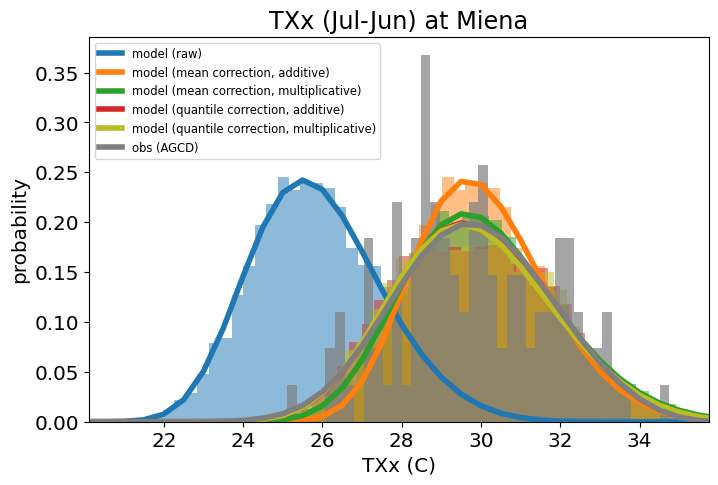

In [59]:
fig, ax = plt.subplots(figsize=[8, 5])
gev_xvals = np.arange(20, 65, 0.5)

da_model_detrended_stacked.plot.hist(bins=40, density=True, color='tab:blue', alpha=0.5)
gev_pdf_model_detrended = gev.pdf(gev_xvals, gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended)
plt.plot(gev_xvals, gev_pdf_model_detrended, color='tab:blue', linewidth=4.0, label='model (raw)')

da_model_detrended_bc_mean_add_stacked.plot.hist(bins=40, density=True, color='tab:orange', alpha=0.5)
gev_pdf_model_detrended_bc_mean_add = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_mean_add,
    gev_loc_model_detrended_bc_mean_add,
    gev_scale_model_detrended_bc_mean_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_mean_add,
    color='tab:orange',
    linewidth=4.0,
    label='model (mean correction, additive)'
)

da_model_detrended_bc_mean_mulc_stacked.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
gev_pdf_model_detrended_bc_mean_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_mean_mulc,
    gev_loc_model_detrended_bc_mean_mulc,
    gev_scale_model_detrended_bc_mean_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_mean_mulc,
    color='tab:green',
    linewidth=4.0,
    label='model (mean correction, multiplicative)'
)

da_model_detrended_bc_quantile_add.plot.hist(bins=40, density=True, color='tab:red', alpha=0.5)
gev_pdf_model_detrended_bc_quantile_add = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_quantile_add,
    gev_loc_model_detrended_bc_quantile_add,
    gev_scale_model_detrended_bc_quantile_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_quantile_add,
    color='tab:red',
    linewidth=4.0,
    label='model (quantile correction, additive)'
)

da_model_detrended_bc_quantile_mulc.plot.hist(bins=40, density=True, color='tab:olive', alpha=0.5)
gev_pdf_model_detrended_bc_quantile_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_quantile_mulc,
    gev_loc_model_detrended_bc_quantile_mulc,
    gev_scale_model_detrended_bc_quantile_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_quantile_mulc,
    color='tab:olive',
    linewidth=4.0,
    label='model (quantile correction, multiplicative)'
)

da_obs_detrended.plot.hist(bins=40, density=True, color='tab:gray', alpha=0.7)
gev_pdf_obs_detrended = gev.pdf(gev_xvals, gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended)
plt.plot(gev_xvals, gev_pdf_obs_detrended, color='tab:gray', linewidth=4.0, label='obs (AGCD)')

plt.xlabel('TXx (C)')
plt.ylabel('probability')
plt.title(f'TXx (Jul-Jun) at {location}')

plt.xlim(xmin, xmax)
plt.legend(fontsize='small')
plt.savefig(f'txx_{location}_gevs.png', bbox_inches='tight', facecolor='white')
plt.show()

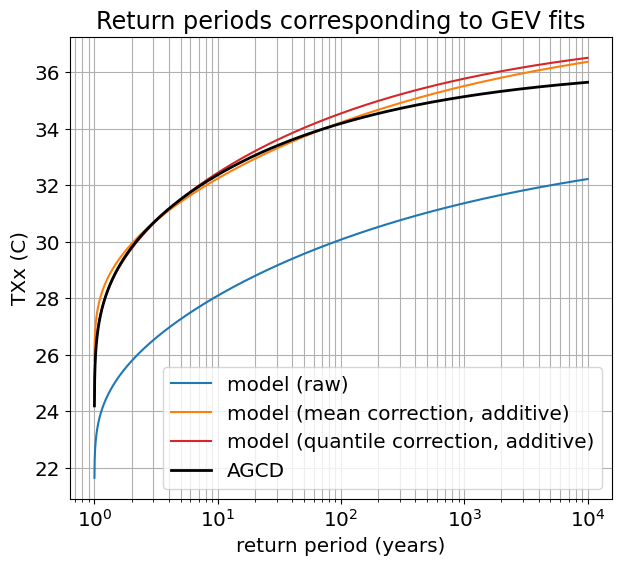

In [60]:
fig = plt.figure(figsize=[7, 6])
#ax1 = fig.add_subplot(211)
#ax2 = fig.add_subplot(212)
ax2 = fig.add_subplot(111)

#ax1.plot(gev_xvals, gev_pdf_model_detrended, color='tab:blue', label='model (raw)')
return_periods_model_detrended, return_values_model_detrended = stability.return_curve(
    da_model_detrended,
    'gev',
    params=[gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended],
)
ax2.plot(return_periods_model_detrended, return_values_model_detrended, label='model (raw)', color='tab:blue')

#ax1.plot(gev_xvals, gev_pdf_model_detrended_bc_mean_add, color='tab:orange', label='model (mean correction, additive)')
return_periods_model_detrended_bc_mean_add, return_values_model_detrended_bc_mean_add = stability.return_curve(
    da_model_detrended_bc_mean_add,
    'gev',
    params=[gev_shape_model_detrended_bc_mean_add, gev_loc_model_detrended_bc_mean_add, gev_scale_model_detrended_bc_mean_add],
)
ax2.plot(return_periods_model_detrended_bc_mean_add, return_values_model_detrended_bc_mean_add, label='model (mean correction, additive)', color='tab:orange')

#ax1.plot(gev_xvals, gev_pdf_model_detrended_bc_quantile_add, color='tab:red', label='model (quantile correction, additive)')
return_periods_model_detrended_bc_quantile_add, return_values_model_detrended_bc_quantile_add = stability.return_curve(
    da_model_detrended_bc_quantile_add,
    'gev',
    params=[gev_shape_model_detrended_bc_quantile_add, gev_loc_model_detrended_bc_quantile_add, gev_scale_model_detrended_bc_quantile_add],
)
ax2.plot(return_periods_model_detrended_bc_quantile_add, return_values_model_detrended_bc_quantile_add, label='model (quantile correction, additive)', color='tab:red')

#ax1.plot(gev_xvals, gev_pdf_obs_detrended, color='black', linewidth=2.0, label='AGCD')
return_periods_obs_detrended, return_values_obs_detrended = stability.return_curve(
    da_obs_detrended,
    'gev',
    params=[gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended],
)
ax2.plot(return_periods_obs_detrended, return_values_obs_detrended, label='AGCD', color='black', linewidth=2.0)

#ax1.grid()
#ax1.set_xlabel('TXx (C)')
#ax1.set_ylabel('probability')
#ax1.axvline(agcd_max, color='0.5', linestyle='--')
#ax1.set_title('(a) GEV fit to data')
#ax1.set_xlim([0, 450])
#ax1.legend()

ax2.legend()
#ax2.axhline(agcd_max, color='0.5', linestyle='--')
ax2.set_xscale('log')
ax2.set_xlabel('return period (years)')
ax2.set_ylabel('TXx (C)')
ax2.set_title('Return periods corresponding to GEV fits')
#ax2.set_ylim([0, 700])
ax2.grid(which='both')
plt.savefig(f'txx_{location}_return_curves.png', bbox_inches='tight', facecolor='white')
plt.show()

### Raw data

In [61]:
similarity_ds = similarity.similarity_tests(da_model_detrended, da_obs_detrended)
print('KS score:', similarity_ds['ks_statistic'].values)
print('KS p-value:', similarity_ds['ks_pval'].values)
print('AD score:', similarity_ds['ad_statistic'].values)
print('AD p-value:', similarity_ds['ad_pval'].values)

KS score: 0.7398687
KS p-value: 0.0
AD score: 292.4944
AD p-value: 0.001


### Additive - mean correction

KS score: 0.3336102
KS p-value: 1.2941594e-11
AD score: 66.569695
AD p-value: 0.001


INFO:root:mean: Obs = 29.827478408813437, Model 95% CI =25.59232283849017 to 26.175736008354175
INFO:root:standard deviation: Obs = 1.961960951298576, Model 95% CI =1.4108058801272265 to 1.8431621741799518
INFO:root:skew: Obs = 0.08355564348133995, Model 95% CI =-0.08867250277343036 to 0.769340854531091
INFO:root:kurtosis: Obs = -0.6162237810463278, Model 95% CI =-0.7161268109165683 to 1.0472128476456584
INFO:root:GEV shape: Obs = 0.2711739380474463, Model 95% CI =0.055169121165550804 to 0.3165557455955272
INFO:root:GEV location: Obs = 29.124443766602433, Model 95% CI =24.946430215866176 to 25.572654779296045
INFO:root:GEV scale: Obs = 1.9283724319217939, Model 95% CI =1.2953878577145868 to 1.7537343916499506
INFO:root:mean: Obs = 29.827478408813437, Bias corrected model 95% CI =29.712263752880933 to 30.34165708209144
INFO:root:standard deviation: Obs = 1.961960951298576, Bias corrected model 95% CI =1.4258632744227442 to 1.8546881419531809
INFO:root:skew: Obs = 0.08355564348133995, Bi

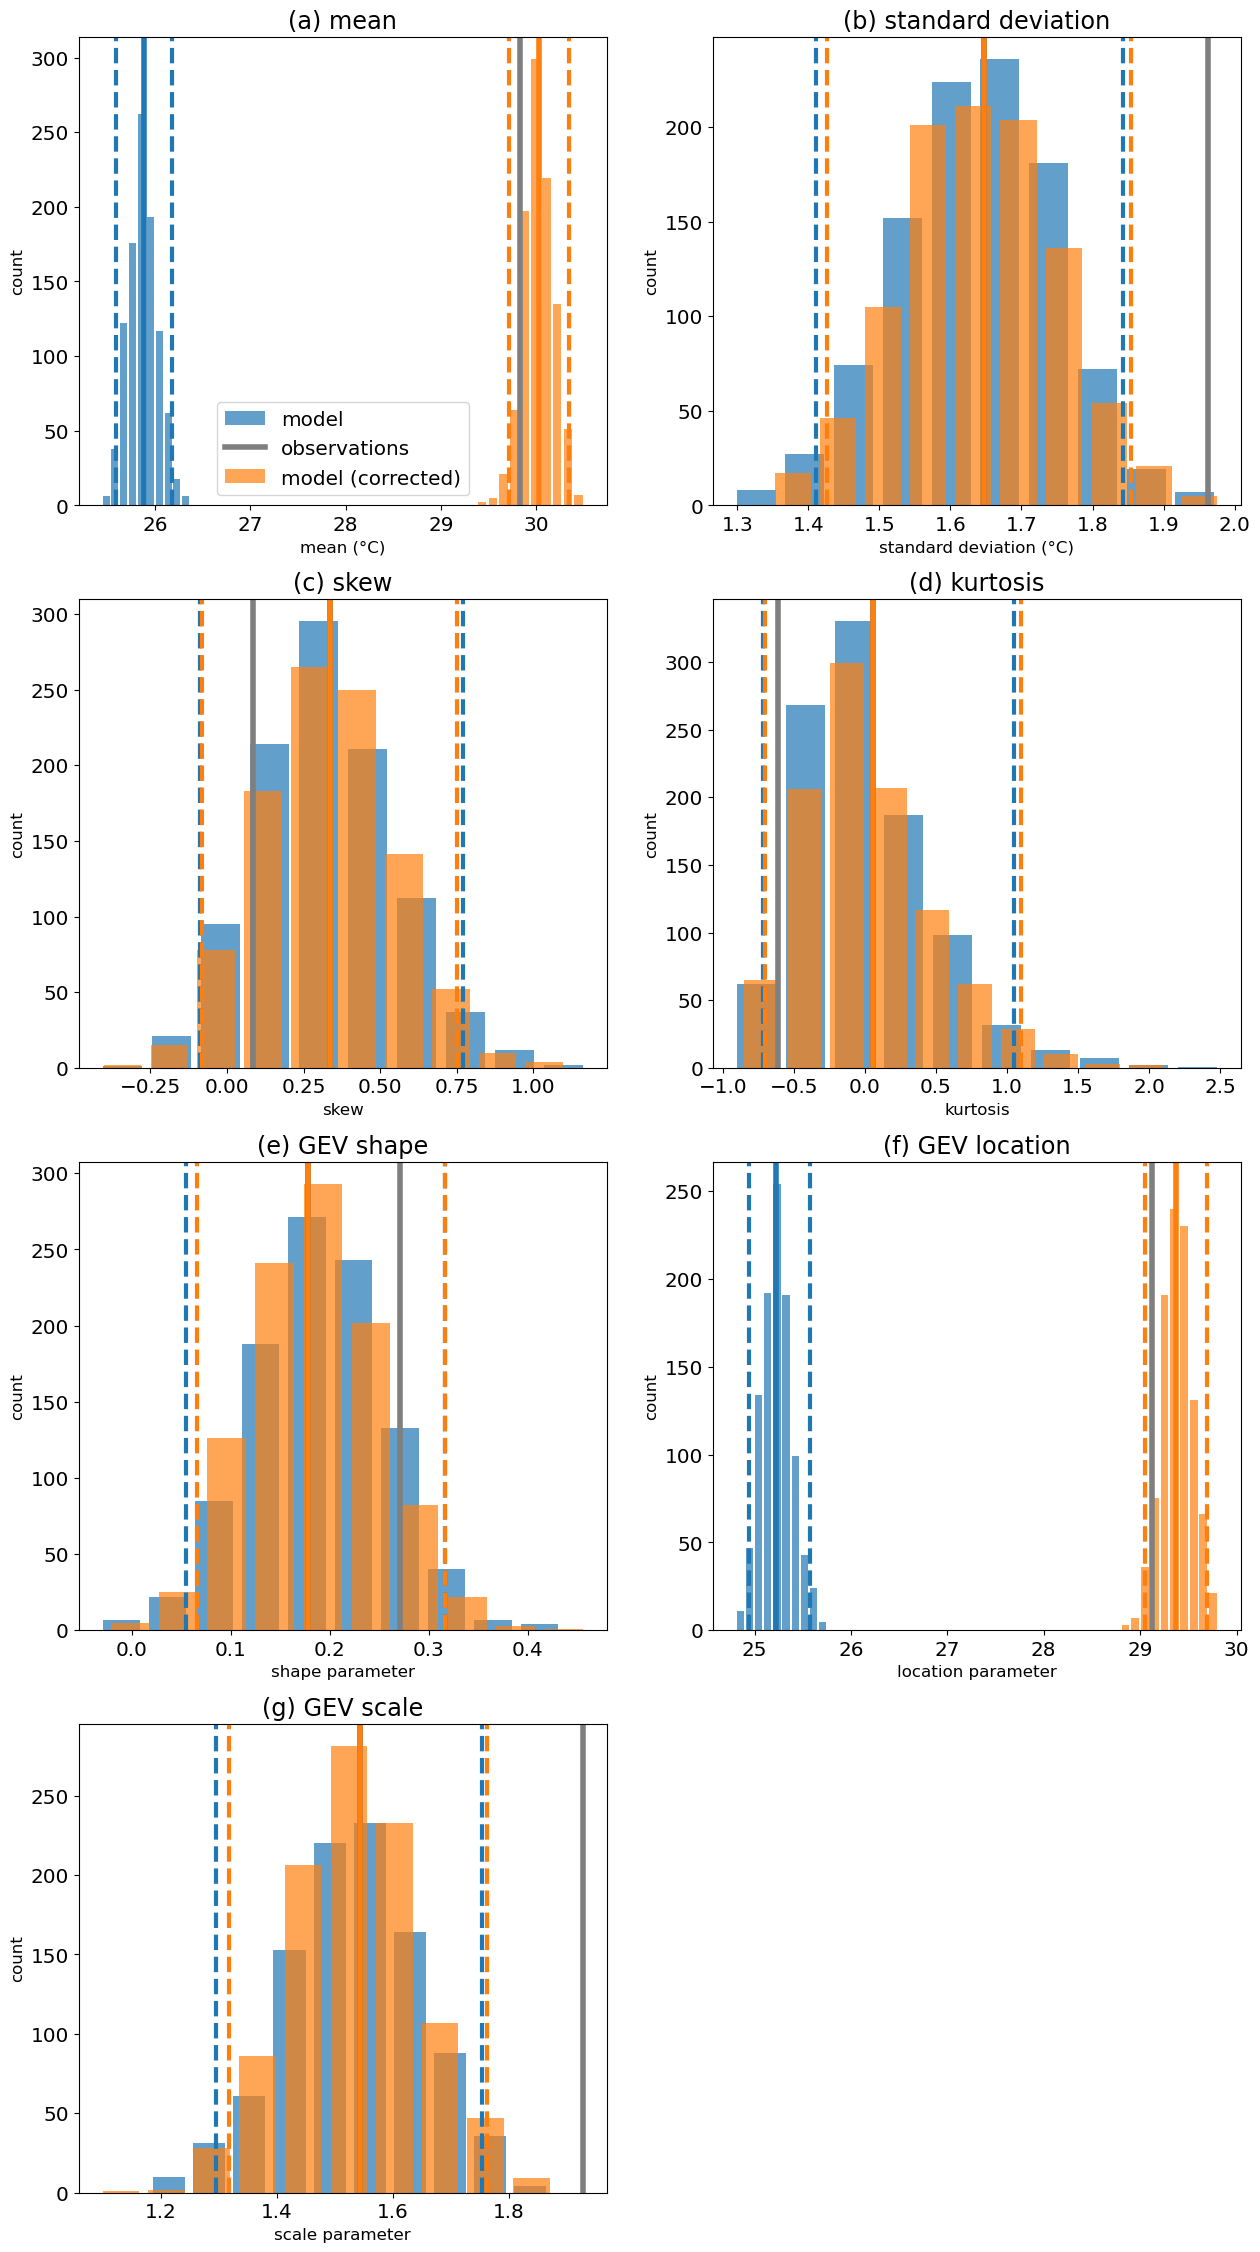

In [62]:
fidelity_tests(da_model_detrended_bc_mean_add)

### Multiplicative - mean correction

KS score: 0.30144647
KS p-value: 1.5925059e-09
AD score: 47.60845
AD p-value: 0.001


INFO:root:mean: Obs = 29.827478408813437, Model 95% CI =25.590504484338748 to 26.184274489972736
INFO:root:standard deviation: Obs = 1.961960951298576, Model 95% CI =1.427176748487299 to 1.856193262655256
INFO:root:skew: Obs = 0.08355564348133995, Model 95% CI =-0.061953972270272835 to 0.7259812130692473
INFO:root:kurtosis: Obs = -0.6162237810463278, Model 95% CI =-0.7033293259418466 to 1.1731124625476983
INFO:root:GEV shape: Obs = 0.2711739380474463, Model 95% CI =0.07083503627674625 to 0.31648157865483684
INFO:root:GEV location: Obs = 29.124443766602433, Model 95% CI =24.918777184793754 to 25.553873479500833
INFO:root:GEV scale: Obs = 1.9283724319217939, Model 95% CI =1.3224815220182207 to 1.7574421799251285
INFO:root:mean: Obs = 29.827478408813437, Bias corrected model 95% CI =29.657876152021153 to 30.39064271649327
INFO:root:standard deviation: Obs = 1.961960951298576, Bias corrected model 95% CI =1.6343813525713773 to 2.151372078288396
INFO:root:skew: Obs = 0.08355564348133995, Bi

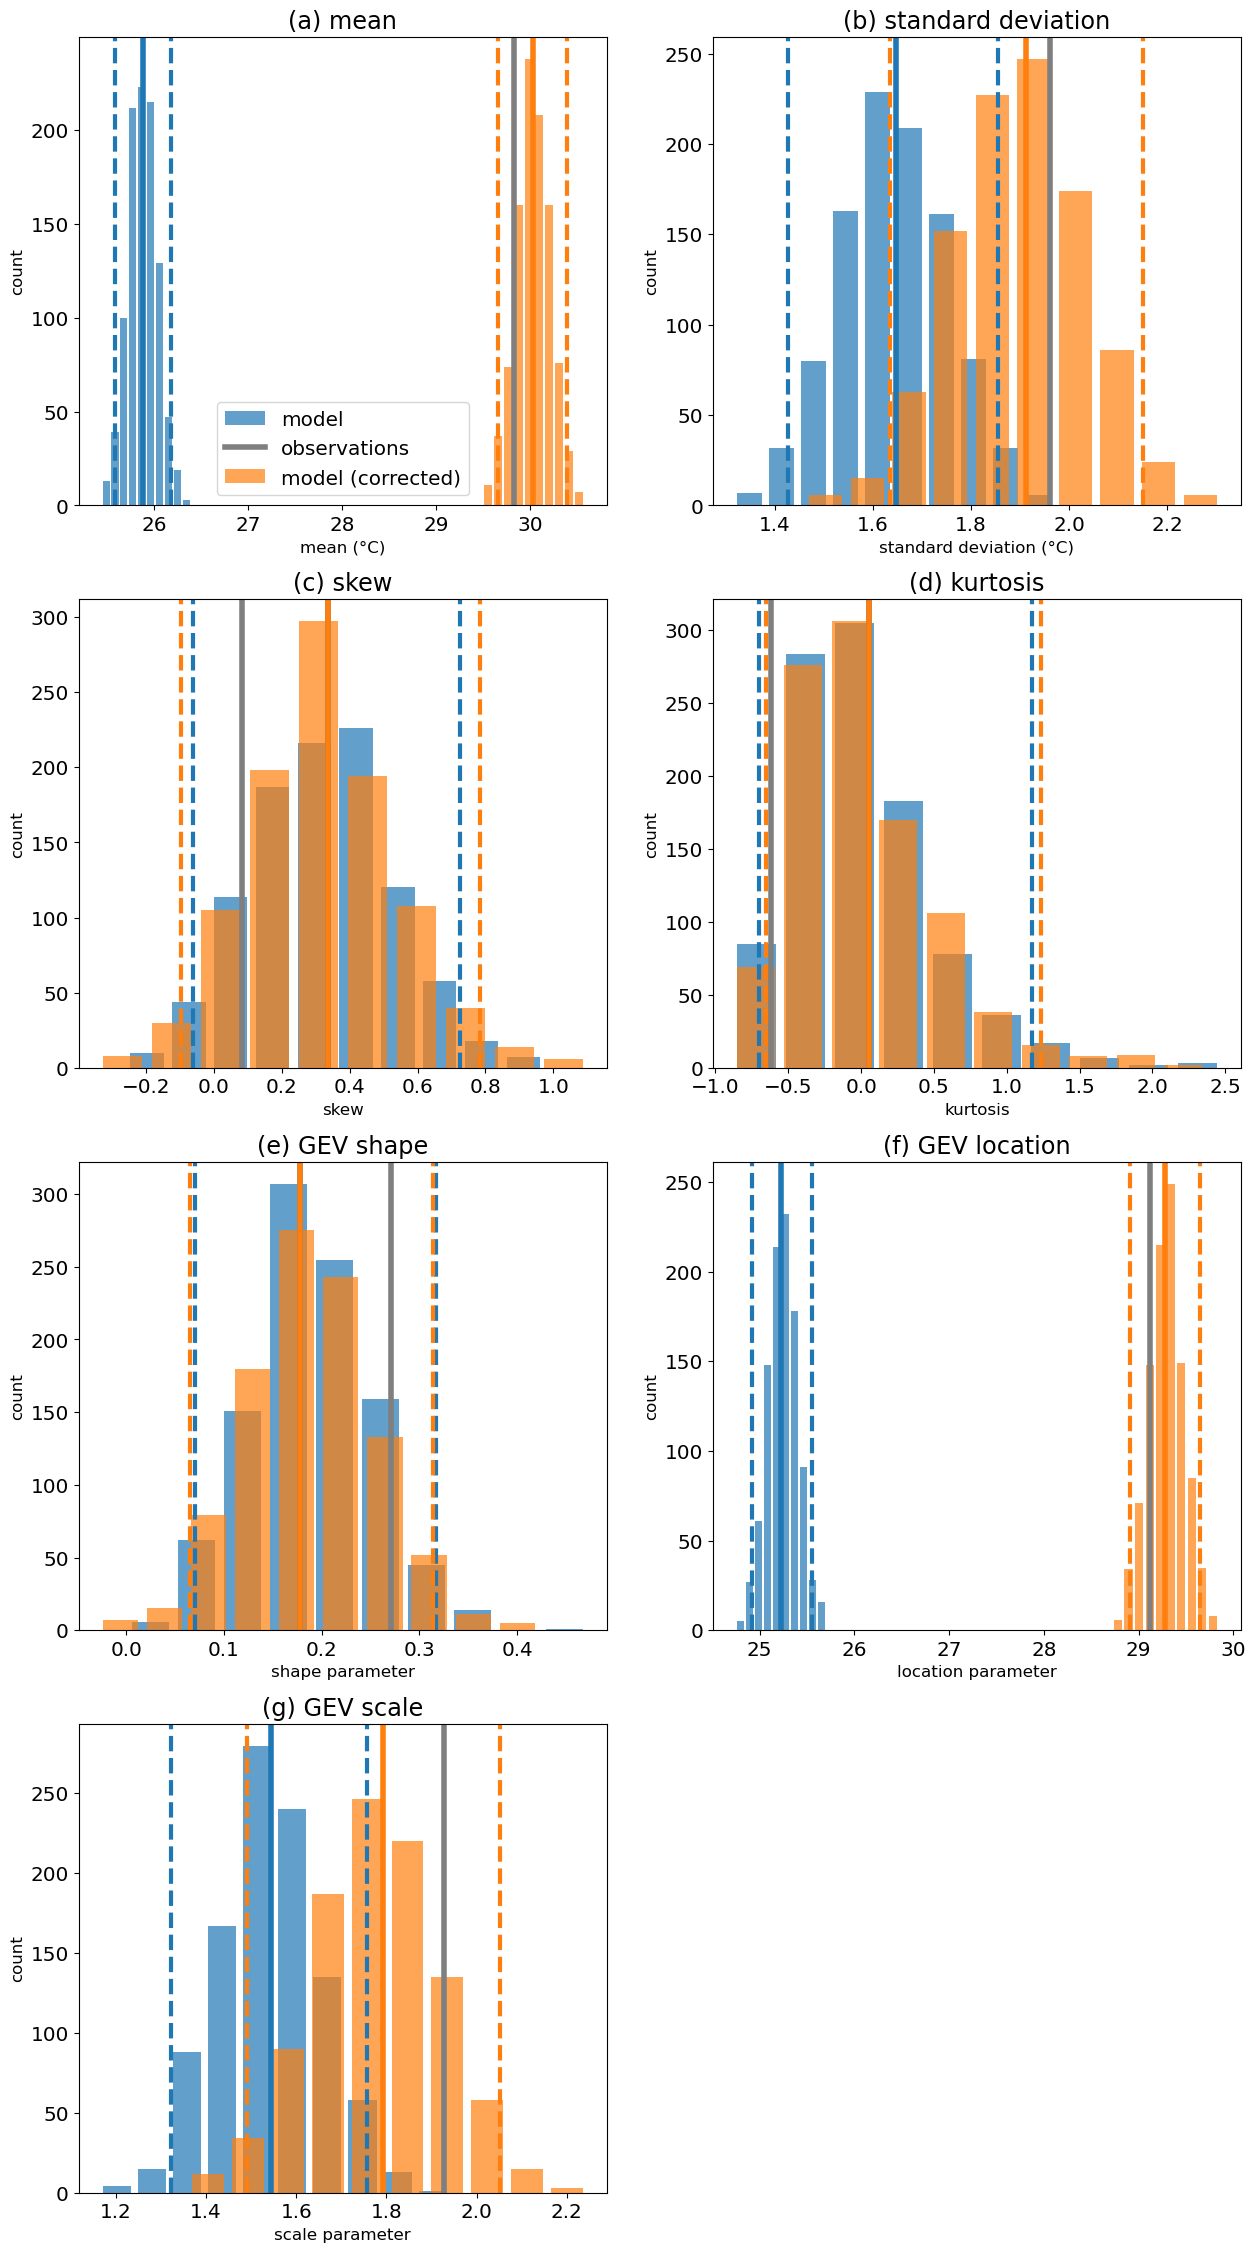

In [63]:
fidelity_tests(da_model_detrended_bc_mean_mulc)

### Additive - quantile correction

KS score: 0.2617399
KS p-value: 2.9344434e-07
AD score: 34.41646
AD p-value: 0.001


INFO:root:mean: Obs = 29.827478408813437, Model 95% CI =25.57580719868355 to 26.175229330281457
INFO:root:standard deviation: Obs = 1.961960951298576, Model 95% CI =1.4340816393021947 to 1.8481311641841998
INFO:root:skew: Obs = 0.08355564348133995, Model 95% CI =-0.08145894903880528 to 0.781761958071326
INFO:root:kurtosis: Obs = -0.6162237810463278, Model 95% CI =-0.6550132562473755 to 1.0598433803246394
INFO:root:GEV shape: Obs = 0.2711739380474463, Model 95% CI =0.06967120585477128 to 0.32194070717105755
INFO:root:GEV location: Obs = 29.124443766602433, Model 95% CI =24.936473593170508 to 25.554191491909098
INFO:root:GEV scale: Obs = 1.9283724319217939, Model 95% CI =1.3157750772947752 to 1.7431129114835675
INFO:root:mean: Obs = 29.827478408813437, Bias corrected model 95% CI =29.481272632272546 to 30.221952029668287
INFO:root:standard deviation: Obs = 1.961960951298576, Bias corrected model 95% CI =1.742965133219437 to 2.198073602758097
INFO:root:skew: Obs = 0.08355564348133995, Bia

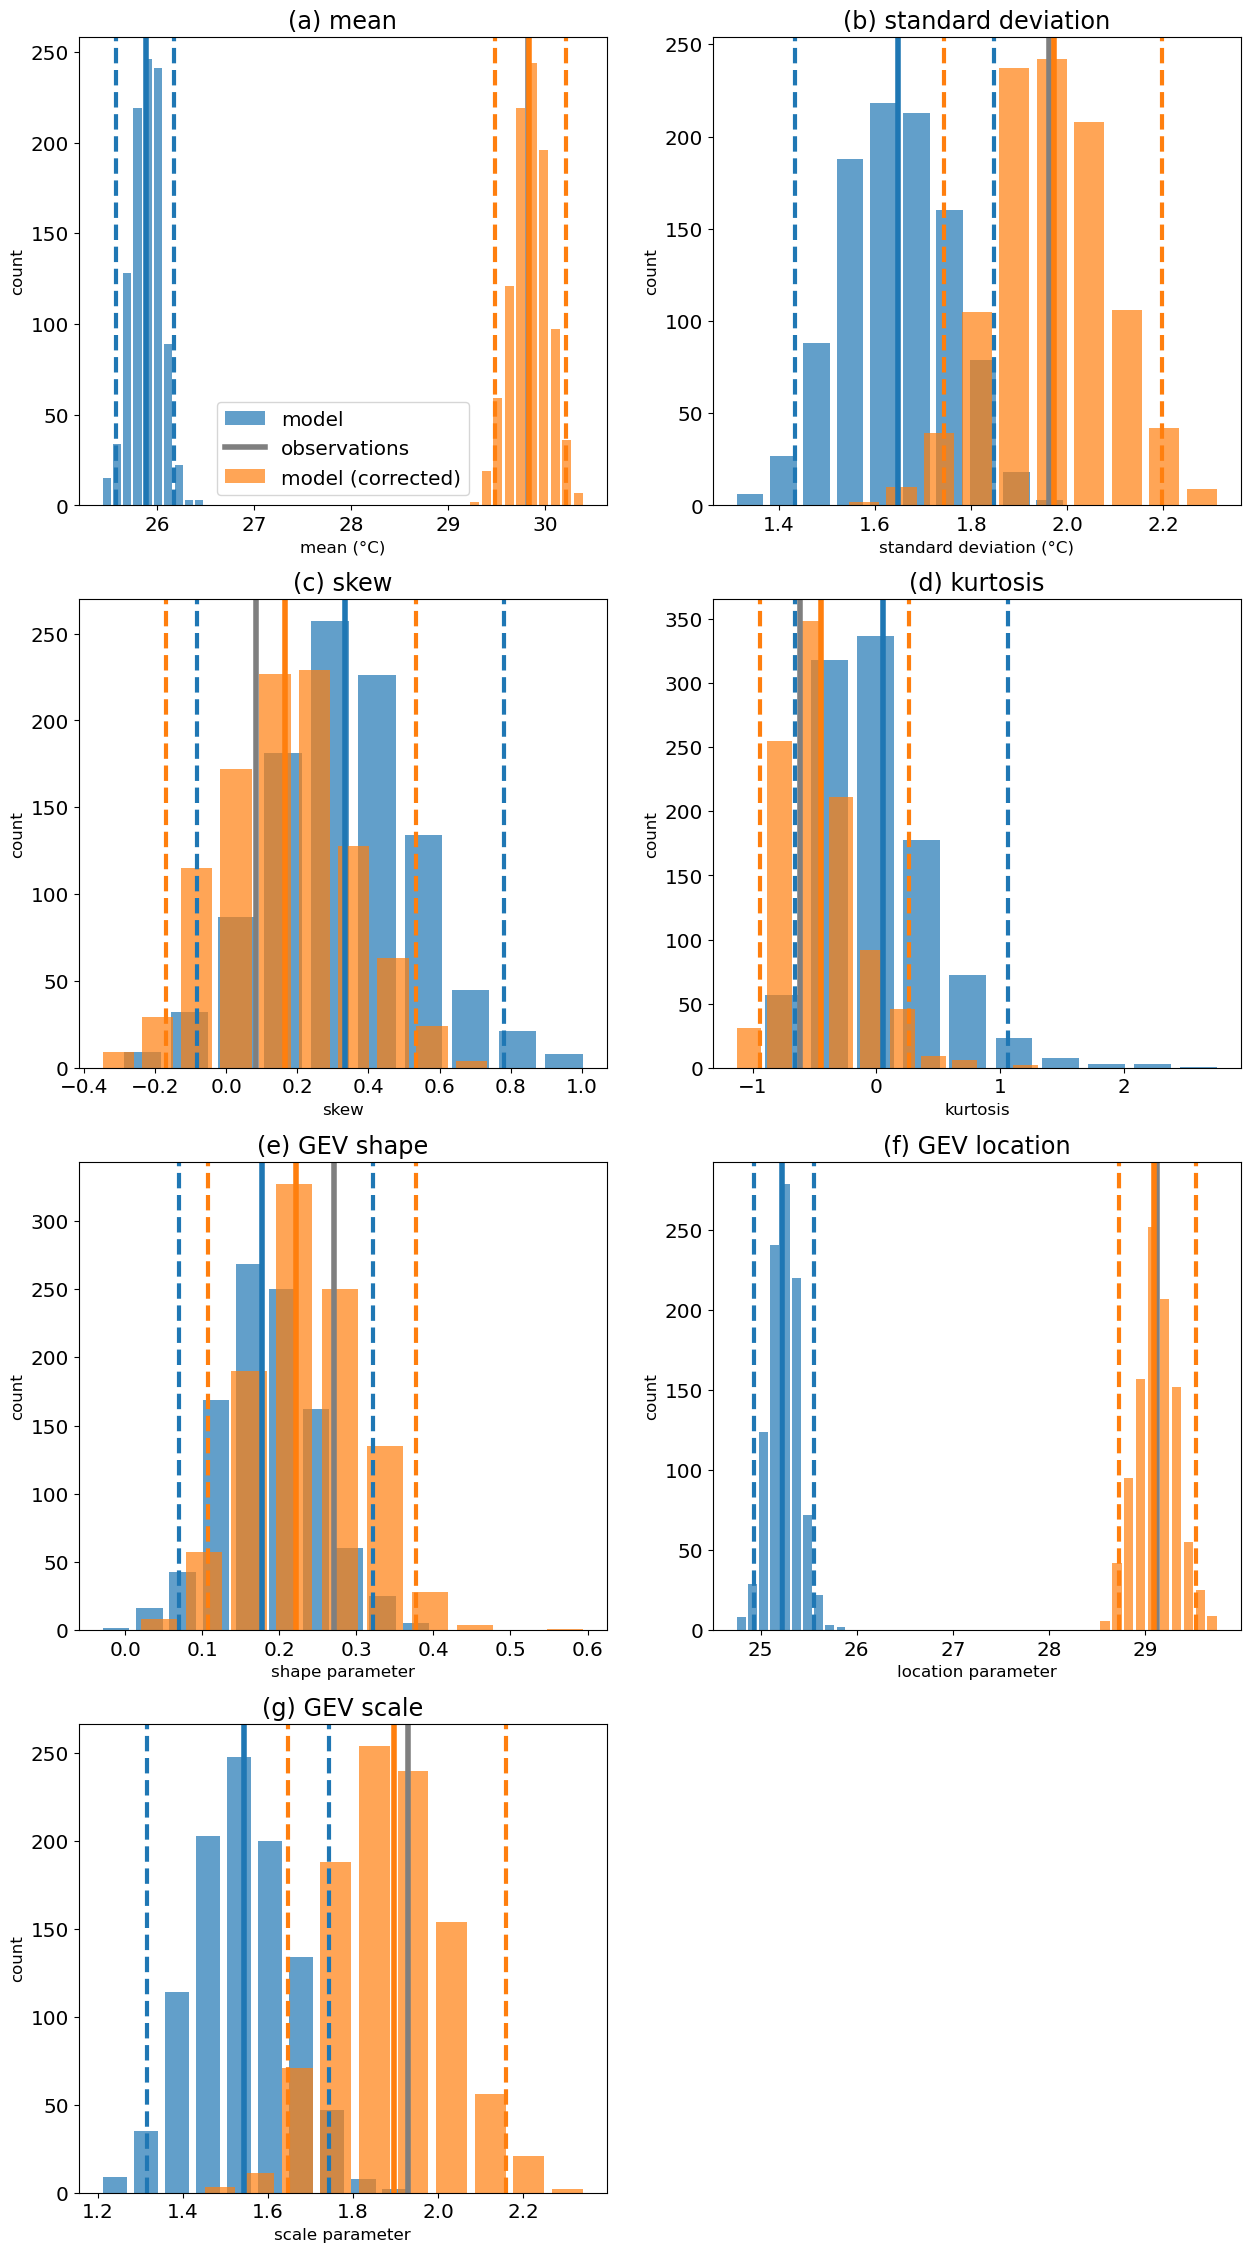

In [64]:
fidelity_tests(da_model_detrended_bc_quantile_add.unstack())

### Multiplicative - quantile correction

KS score: 0.26281202
KS p-value: 2.5753255e-07
AD score: 33.008743
AD p-value: 0.001


INFO:root:mean: Obs = 29.827478408813437, Model 95% CI =25.57592321925982 to 26.193317806784794
INFO:root:standard deviation: Obs = 1.961960951298576, Model 95% CI =1.4299640553440118 to 1.854042036755713
INFO:root:skew: Obs = 0.08355564348133995, Model 95% CI =-0.06577315744352354 to 0.7551849585998694
INFO:root:kurtosis: Obs = -0.6162237810463278, Model 95% CI =-0.664834810511546 to 1.1399887552906336
INFO:root:GEV shape: Obs = 0.2711739380474463, Model 95% CI =0.057645403474122114 to 0.3140837666577699
INFO:root:GEV location: Obs = 29.124443766602433, Model 95% CI =24.92832885716238 to 25.542671479865962
INFO:root:GEV scale: Obs = 1.9283724319217939, Model 95% CI =1.3161466588896262 to 1.7615139935688857
INFO:root:mean: Obs = 29.827478408813437, Bias corrected model 95% CI =29.46460898687866 to 30.202321245394117
INFO:root:standard deviation: Obs = 1.961960951298576, Bias corrected model 95% CI =1.7468776840392306 to 2.2158416729772776
INFO:root:skew: Obs = 0.08355564348133995, Bias

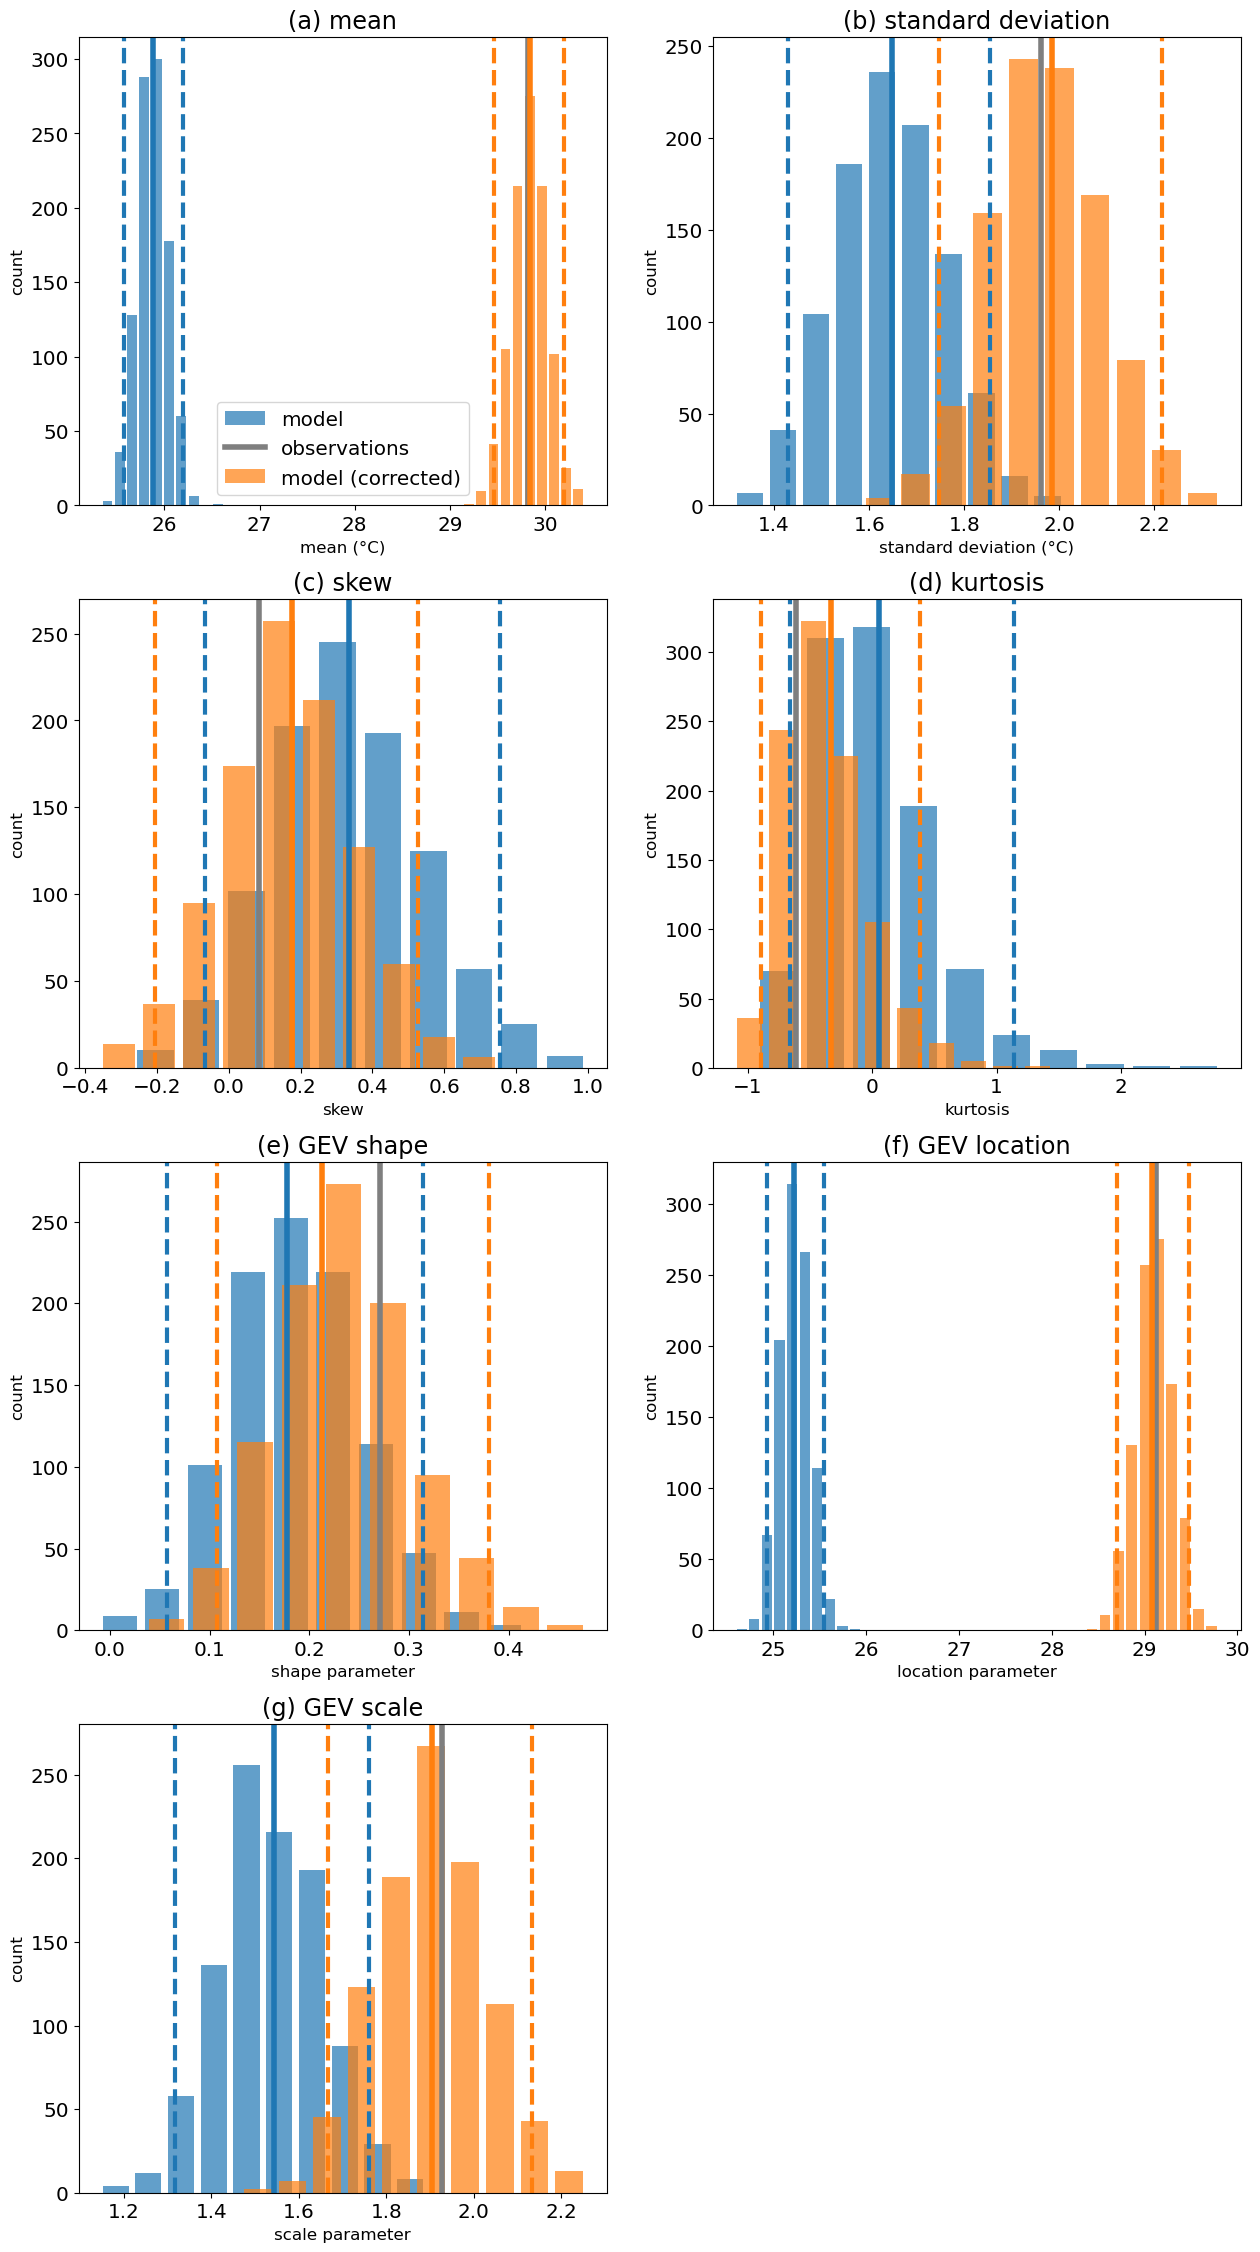

In [65]:
fidelity_tests(da_model_detrended_bc_quantile_mulc.unstack())